In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import numpy as np
import pandas as pd
import pickle as pkl

import sys
sys.path.append('../')
from basiss.preprocessing import Sample
from basiss.models import sample_essential
from basiss.histology import Histogenomic_associations, output_ducts_composition_raw, output_cell_composition_raw
from basiss.histology.plots import vulcano_plot_glmm
from basiss.plots import plot_field
from collections import Counter

from basiss.utils import boxplot_annotate_brackets
from scipy.stats import fisher_exact

mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams['figure.facecolor'] = 'white'

In [2]:
%load_ext autoreload
%autoreload 2

### Sample and clone notation
For simplicity, manuscript uses a different set of notation for patients, tissue samples and clones. The aliases are:

**Patients (cancer case)**
P1 = Patient PD9694
P2 = Patient PD14780

**Samples**
PD1-D1 = PD9694d
PD1-D2 = PD9694l
PD1-D3 = PD9694m
PD1-ER1 = PD9694a
PD1-ER2 = PD9694c
PD2-TN1 = PD14780a
PD2-TN2 = PD14780d
PD2-LN = PD14780e

**Clones** - have the same naming pattern, but in manuscript patient is specified, e.g. P1-orange, P2-purple

### Assemble histogenomic association data

We combine multiple level of information obtained previously, such as histology, cell composition, cell type specific expression and genetic maps in a `basiss.histology.Histogenomic_associations` class. 

In [3]:
#Case and sections to analyse
list_of_samples_case1 = ['PD9694' + letter for letter in 'dacl']
n_factors_case1 = 8 
list_of_samples_case2 = ['PD14780' + letter for letter in 'ae']
n_factors_case2 = 6

In [4]:
with open('../submission/generated_data/data_structures/data_case1_saved.pkl', 'rb') as file:
    saved_lists = pkl.load(file)
mut_sample_list_case1 = saved_lists['mut_sample_list']
exp_sample_list_case1 = saved_lists['exp_sample_list']
imm_sample_list_case1 = saved_lists['imm_sample_list']

with open('../submission/generated_data/models/PD9694_bassis_model_params.pkl', 'rb') as file:
    essential_params_case1 = pkl.load(file)
    
with open('../submission/generated_data/data_structures/data_case2_saved.pkl', 'rb') as file:
    saved_lists = pkl.load(file)
mut_sample_list_case2 = saved_lists['mut_sample_list']
exp_sample_list_case2 = saved_lists['exp_sample_list']
imm_sample_list_case2 = saved_lists['imm_sample_list']

with open('../submission/generated_data/models/PD14780_bassis_model_params.pkl', 'rb') as file:
    essential_params_case2 = pkl.load(file)

In [5]:
model_params_samples_case1 = sample_essential(essential_params_case1,
                                        n_factors=n_factors_case1,
                                        samples=[0,1,2,3,4],
                                        n_draws=500, seed=52)
model_params_samples_case2 = sample_essential(essential_params_case2,
                                        n_factors=n_factors_case2,
                                        samples=[0,1,2],
                                        n_draws=500, seed=52)

100%|██████████| 3/3 [00:07<00:00,  2.39s/it]


In [7]:
raw_compositions = {}
inner_cell_composition = {}
outer_cell_composition = {}

inner_expression = {}
outer_expression = {}

for i, sample in zip([0,1,2,3], 'dacl'):
    print(f'PD9694{sample}')
    raw_comp = output_ducts_composition_raw(mut_sample_list_case1, model_params_samples_case1, i)
    raw_compositions[f'PD9694{sample}'] = raw_comp
    
    sample_panel_list = [exp_sample_list_case1[i], imm_sample_list_case1[i]]
    cell_type_df_list = [pd.read_csv(f'../submission/generated_data/sc_iss_annotations/PD9694{sample}_expression_nuclei_annot.csv', index_col=0),
                         pd.read_csv(f'../submission/generated_data/sc_iss_annotations/PD9694{sample}_immune_nuclei_annot.csv', index_col=0)]

    expression_type_df_list = [pd.read_csv(f'../submission/generated_data/sc_iss_annotations/PD9694{sample}_expression_expression_per_nucleus.csv', index_col=0),
                               pd.read_csv(f'../submission/generated_data/sc_iss_annotations/PD9694{sample}_immune_expression_per_nucleus.csv', index_col=0)]

    inner_comp, inner_exp  = output_cell_composition_raw(sample_panel_list, cell_type_df_list, expression_type_df_list, mode='inner')
    inner_cell_composition[f'PD9694{sample}'] = inner_comp
    inner_expression[f'PD9694{sample}'] = inner_exp
    
    outer_comp, outer_exp = output_cell_composition_raw(sample_panel_list, cell_type_df_list, expression_type_df_list, mode='outer')
    outer_cell_composition[f'PD9694{sample}'] = outer_comp
    outer_expression[f'PD9694{sample}'] = outer_exp
    
for i, sample in zip([0,2], 'ae'):
    print(f'PD14780{sample}')
    raw_comp = output_ducts_composition_raw(mut_sample_list_case2, model_params_samples_case2, i)
    raw_compositions[f'PD14780{sample}'] = raw_comp
    
    sample_panel_list = [exp_sample_list_case2[i], imm_sample_list_case2[i]]
    cell_type_df_list = [pd.read_csv(f'../submission/generated_data/sc_iss_annotations/PD14780{sample}_expression_nuclei_annot.csv', index_col=0),
                         pd.read_csv(f'../submission/generated_data/sc_iss_annotations/PD14780{sample}_immune_nuclei_annot.csv', index_col=0)]

    expression_type_df_list = [pd.read_csv(f'../submission/generated_data/sc_iss_annotations/PD14780{sample}_expression_expression_per_nucleus.csv', index_col=0),
                               pd.read_csv(f'../submission/generated_data/sc_iss_annotations/PD14780{sample}_immune_expression_per_nucleus.csv', index_col=0)]

    inner_comp, inner_exp  = output_cell_composition_raw(sample_panel_list, cell_type_df_list, expression_type_df_list, mode='inner')
    inner_cell_composition[f'PD14780{sample}'] = inner_comp
    inner_expression[f'PD14780{sample}'] = inner_exp

  0%|          | 0/56 [00:00<?, ?it/s]

PD9694d


  0%|          | 0/56 [00:00<?, ?it/s]

PD9694a


  0%|          | 0/56 [00:00<?, ?it/s]

PD9694c


  2%|▏         | 1/55 [00:00<00:06,  8.62it/s]

PD9694l


  5%|▍         | 1/21 [00:00<00:02,  7.49it/s]

PD14780a


  0%|          | 0/21 [00:00<?, ?it/s]

PD14780e


100%|██████████| 21/21 [00:01<00:00, 15.36it/s]


In [8]:
hgas = []
for i, sample in enumerate('dacl'):
    tmp = pd.read_csv(f'../submission/external_data/PD9694/histopath_annot/PD9694{sample}_histopath_annot.csv')
    tmp.index = tmp.iloc[:,0].astype(str).str.upper()
    extra_dfs = {'inner_onco': inner_cell_composition[f'PD9694{sample}'][0],
                 'inner_immune': inner_cell_composition[f'PD9694{sample}'][1],
                 'outer_onco': outer_cell_composition[f'PD9694{sample}'][0],
                 'outer_immune': outer_cell_composition[f'PD9694{sample}'][1],
                 'epithelial': inner_expression[f'PD9694{sample}'][0]['Epithelial broad'],
                 'CAFs_outer': outer_expression[f'PD9694{sample}'][0]['Fibroblasts + PVL'],
                 'CAFs_inner': inner_expression[f'PD9694{sample}'][0]['Fibroblasts + PVL'],
                 'stromal_0_outer': outer_expression[f'PD9694{sample}'][0]['Stromal broad'],
                 'stromal_0_inner': inner_expression[f'PD9694{sample}'][0]['Stromal broad'],
                 'stromal_1_outer': outer_expression[f'PD9694{sample}'][1]['Stromal broad'],
                 'stromal_1_inner': inner_expression[f'PD9694{sample}'][1]['Stromal broad'],
                 'immune_outer': outer_expression[f'PD9694{sample}'][1]['Immune total'],
                 'immune_inner': inner_expression[f'PD9694{sample}'][1]['Immune total'],
                 'myeloid_outer': outer_expression[f'PD9694{sample}'][1]['Myeloid'],
                 'myeloid_inner': inner_expression[f'PD9694{sample}'][1]['Myeloid'],
                 't-cell_outer': outer_expression[f'PD9694{sample}'][1]['T-cells'],
                 't-cell_inner': inner_expression[f'PD9694{sample}'][1]['T-cells']}
    hga = Histogenomic_associations(tmp, raw_compositions[f'PD9694{sample}'], extra_dfs=extra_dfs)
    hga.subset_ids(comp_condition=hga.exist_comp_condition())
    hgas.append(hga)

for i, sample in enumerate('ae'):
    tmp = pd.read_csv(f'../submission/external_data/PD14780/histopath_annot/PD14780{sample}_histopath_annot.csv')
    tmp.index = tmp.iloc[:,0].astype(str).str.upper()
    if sample == 'e':
        tmp = tmp.astype('category')

    extra_dfs = {'inner_onco': inner_cell_composition[f'PD14780{sample}'][0],
                 'inner_immune': inner_cell_composition[f'PD14780{sample}'][1],
                 'epithelial': inner_expression[f'PD14780{sample}'][0]['Epithelial broad'],
                 'CAFs_inner': inner_expression[f'PD14780{sample}'][0]['Fibroblasts + PVL'],
                 'stromal_0_inner': inner_expression[f'PD14780{sample}'][0]['Stromal broad'],
                 'stromal_1_inner': inner_expression[f'PD14780{sample}'][1]['Stromal broad'],
                 'immune_inner': inner_expression[f'PD14780{sample}'][1]['Immune total'],
                 'myeloid_inner': inner_expression[f'PD14780{sample}'][1]['Myeloid'],
                 't-cell_inner': inner_expression[f'PD14780{sample}'][1]['T-cells']}
    
    hga = Histogenomic_associations(tmp, raw_compositions[f'PD14780{sample}'], extra_dfs=extra_dfs)
    hga.subset_ids(comp_condition=hga.exist_comp_condition())
    
    hgas.append(hga)

for i in range(6):
    hgas[i].extra_dfs['inner_immune']['Immune total'] = hgas[i].extra_dfs['inner_immune'][['Myeloid', 'T-cells', 'B-cells', 'Immune broad']].sum(1)

/nfs/research/gerstung/alomakin/projects/bassis/repo/BaSISS/notebooks/../basiss/histology/_histogenomic.py:84: RuntimeWarning: invalid value encountered in double_scalars
  if self.composition_dict[item].mean(axis=0)[:-1].sum() / self.composition_dict[item].mean(axis=0).sum()  > th:


In [9]:
with open('../submission/generated_data/histogenomics/hgas.pkl', 'wb') as f:
    pkl.dump(hgas, f)

In [10]:
with open('../submission/generated_data/histogenomics/hgas.pkl', 'rb') as f:
    hgas = pkl.load(f)

In [11]:
### stats on the number of histo-regions:
sample_ids = ['PD9694' + x for x in 'dacl'] + ['PD14780' + x for x in 'ae'] 

s = 0
for i, sid in enumerate(sample_ids):
    print(sid, len(hgas[i].common_ids))
    s += len(hgas[i].common_ids)
print('total', s)

PD9694d 108
PD9694a 38
PD9694c 45
PD9694l 40
PD14780a 36
PD14780e 80
total 347


### Display maps and histological contours

<b>Fig 4A; ED Fig 7A,D,E</b> BaSISS maps of most prevalent genetic clones projected on DAPI images (reported if cancer cell fraction > 25% and inferred local cell density > 300 cells/mm2). White contours mark 114 and 40 histologically annotated microregions in D1 and D2. Dashed and solid contours represent grade 1 and grade 2 pathological characteristic of the region respectively.

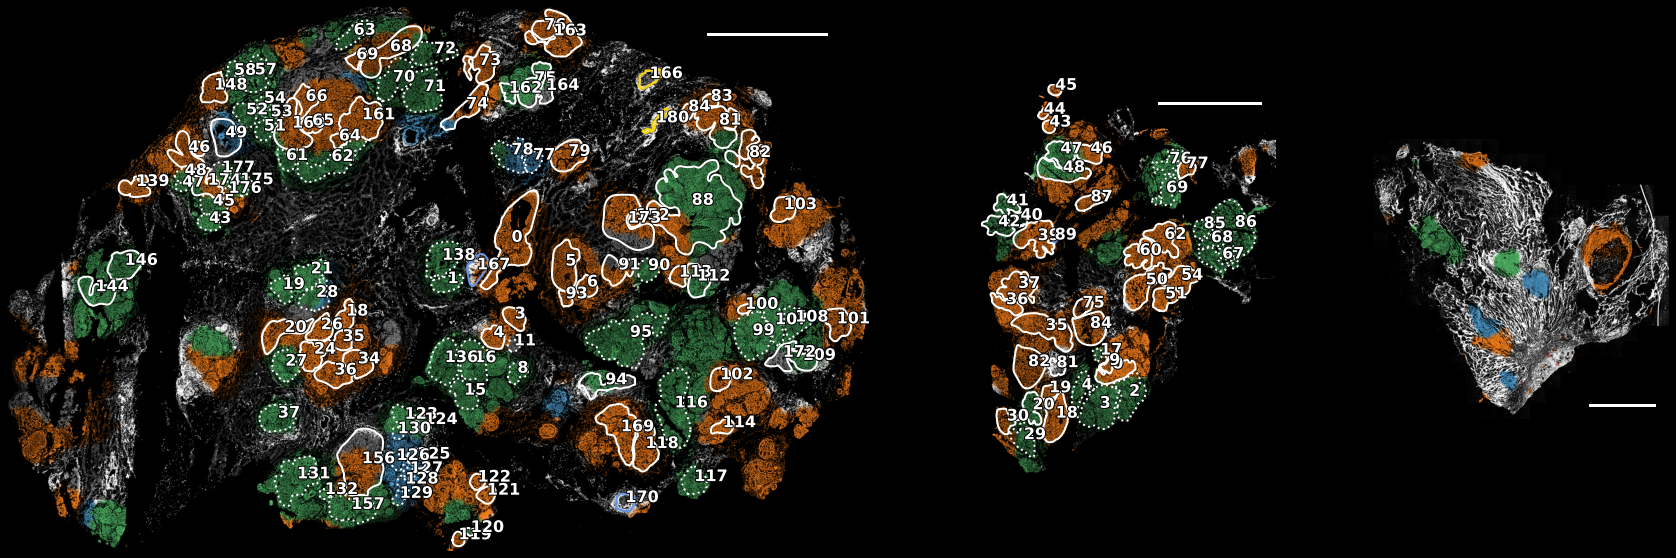

In [12]:
#D1 D2 D3
fig, ax = plt.subplots(1,3,figsize=(30,10), gridspec_kw={'width_ratios': [3,1,1]})
fig.set_facecolor('black')
params = [model_params_samples_case1,
          model_params_samples_case1,
          model_params_samples_case1]
sample_list = [mut_sample_list_case1[0],
               mut_sample_list_case1[3],
               mut_sample_list_case1[4]]
names=[['grey', 'green', 'purple', 'blue', 'red', 'orange'],
       ['grey', 'green', 'purple', 'blue', 'red', 'orange'],
       ['grey', 'green', 'purple', 'blue', 'red', 'orange']]
ns = [0,3,4]
flips = [True, True, False]
for i in range(3):
    plot_field(sample_list[i],
               params[i][f'F_{ns[i]}'],
               params[i][f'lm_n_{ns[i]}'],
               ax=ax[i],
               names=names[i],
               flip=flips[i],
               th=[0.75, 0.75, 0.75, 0.75])

for c, n in zip([0,1], [0,3]):
    ax[c].invert_yaxis()
    annot_processed = hgas[n].histology_df
    for i_d, line in zip(mut_sample_list_case1[n].ducts['id'], mut_sample_list_case1[n].ducts['paths']):
        try:
            if annot_processed.loc[i_d,'Epithelial cells'] == 'Normal, epithelium':
                ax[c].plot(*line.T/15, color='cornflowerblue', linestyle='solid', lw=2)
            elif annot_processed.loc[i_d,'Epithelial cells'] == 'Normal, stroma':
                ax[c].plot(*line.T/15, color='cornflowerblue', linestyle='solid', lw=2)
            elif annot_processed.loc[i_d,'Epithelial cells'] == 'Hyperplasia':
                ax[c].plot(*line.T/15, color='gold', linestyle='solid', lw=2) 
            elif annot_processed.loc[i_d,'Epithelial cells'] == 'DCIS':
                if annot_processed.loc[i_d,'Grade'] == 'Low':
                    ax[c].plot(*line.T/15, color='white', linestyle='dotted', lw=2)
                elif annot_processed.loc[i_d,'Grade'] == 'Intermediate':
                    ax[c].plot(*line.T/15, color='white', linestyle='solid', lw=2)
            elif annot_processed.loc[i_d,'Epithelial cells'] == 'Invasive':
                ax[c].plot(*line.T/15, color='violet', linestyle='dotted', lw=2)
            txt = ax[c].text(*line.T.mean(1)/15, s=i_d, color='white', fontdict={'size': 16, 'weight':'bold'})
            txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='black')])
        except KeyError:
            pass
plt.savefig('../figures/Fig4A_maps_with_names.pdf', dpi=150)

<b>Fig 3A,E; ED Fig 5B; ED Fig 6B</b> Most prevalent genetic clones are projected on DAPI images (reported if cancer cell fraction > 25% and inferred local cell density > 300 cells/mm2). Type of the contour represent histological stage:
* solid blue - Normal epithelium or stroma
* solid yellow - Hyperplasia
* solid white - DCIS
* dotted purple - Invasive

specific to TN1:
* dashed blue - Invasive GP1
* dashed purple - Invasive GP2


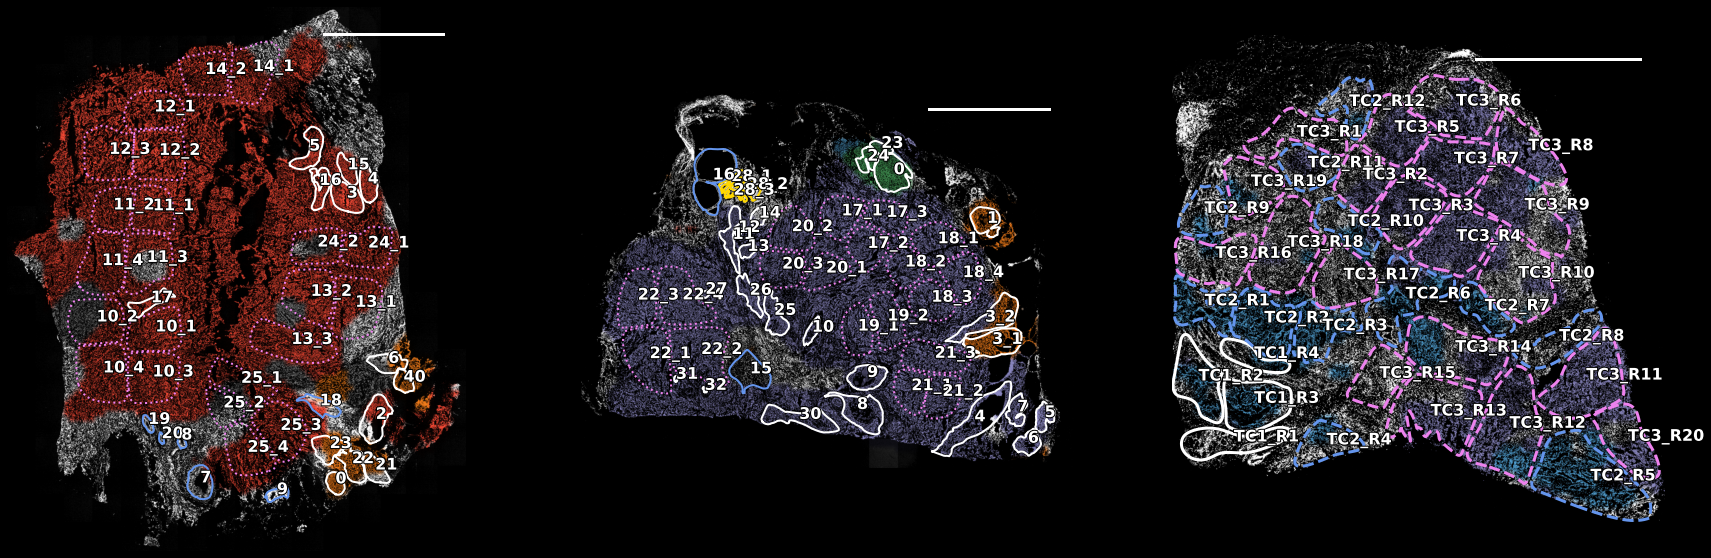

In [13]:
### ER1, ER2, TN1
fig, ax = plt.subplots(1,3,figsize=(30,10))
fig.set_facecolor('black')
params = [model_params_samples_case1,
          model_params_samples_case1,
          model_params_samples_case2]
sample_list = [mut_sample_list_case1[1],
               mut_sample_list_case1[2],
               mut_sample_list_case2[0]]
names=[['grey', 'green', 'purple', 'blue', 'red', 'orange'],
       ['grey', 'green', 'purple', 'blue', 'red', 'orange'],
       ['blue', 'green', 'orange', 'purple']]
ns = [1,2,0]
flips = [True, True, True]
for i in range(3):
    plot_field(sample_list[i],
               params[i][f'F_{ns[i]}'],
               params[i][f'lm_n_{ns[i]}'],
               ax=ax[i],
               names=names[i],
               flip=flips[i],
               th=[0.75, 0.75, 0.75, 0.75])

for c, n in zip([0,1], [1,2]):
    ax[c].invert_yaxis()
    annot_processed = hgas[n].histology_df
    for i_d, line in zip(mut_sample_list_case1[n].ducts['id'], mut_sample_list_case1[n].ducts['paths']):
        if annot_processed.loc[i_d,'Epithelial cells'] == 'Normal, epithelium':
            ax[c].plot(*line.T/15, color='cornflowerblue', linestyle='solid', lw=2)
        elif annot_processed.loc[i_d,'Epithelial cells'] == 'Normal, stroma':
            ax[c].plot(*line.T/15, color='cornflowerblue', linestyle='solid', lw=2)
        elif annot_processed.loc[i_d,'Epithelial cells'] == 'Hyperplasia':
            ax[c].plot(*line.T/15, color='gold', linestyle='solid', lw=2) 
        elif annot_processed.loc[i_d,'Epithelial cells'] == 'DCIS':
            ax[c].plot(*line.T/15, color='white', linestyle='solid', lw=2)
        elif annot_processed.loc[i_d,'Epithelial cells'] == 'Invasive':
            ax[c].plot(*line.T/15, color='violet', linestyle='dotted', lw=2)
        txt = ax[c].text(*line.T.mean(1)/15, s=i_d, color='white', fontdict={'size': 16, 'weight':'bold'})
        txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='black')])
              
c = 2
ax[c].invert_yaxis()
annot_processed = hgas[4].histology_df
for i_d, line in zip(mut_sample_list_case2[0].ducts['id'], mut_sample_list_case2[0].ducts['paths']):
    if i_d.split('_')[0] == 'TC1':
        ax[c].plot(*line.T/15, color='white', linestyle='solid', lw=3)
        txt = ax[c].text(*line.T.mean(1)/15, s=i_d, color='white', fontdict={'size': 16, 'weight':'bold'})
        txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='black')])
    elif i_d.split('_')[0] == 'TC2':
        ax[c].plot(*line.T/15, color='cornflowerblue', linestyle='dashed', lw=3)
        txt = ax[c].text(*line.T.mean(1)/15, s=i_d, color='white', fontdict={'size': 16, 'weight':'bold'})
        txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='black')])
    elif i_d.split('_')[0] == 'TC3':
        ax[c].plot(*line.T/15, color='violet', linestyle='dashed', lw=3)
        txt = ax[c].text(*line.T.mean(1)/15, s=i_d, color='white', fontdict={'size': 16, 'weight':'bold'})
        txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='black')])
        
plt.savefig('../figures/Fig3AE_maps_with_names.pdf', dpi=150)

<b>Fig 5A</b> BaSISS subclone fields in case 2 LN1 (DAPI projected, colour reflects the most prevalent subclone, reported if cancer cell fraction > 25%, threshold of 5% used in regions of diffusely infiltrating blue to allow visualisation in very high normal contamination regions). Type of the contour represent histological stage:
* dashed blue - M-GP1
* dashed purple - M-GP2 out of sinuses
* solid purple - M-GP2 in sinuses

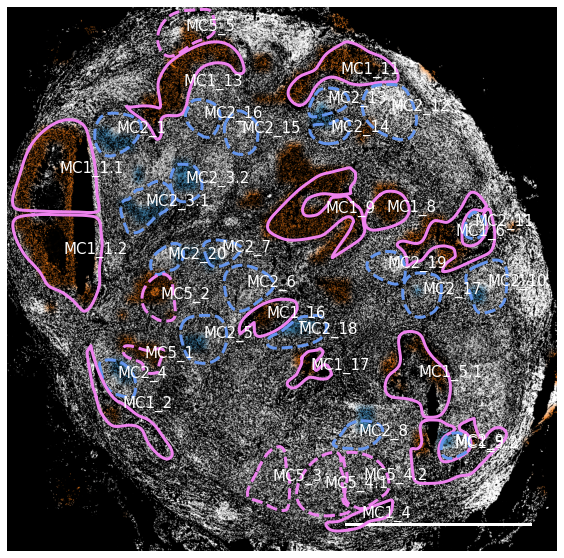

In [14]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
i = 2
plot_field(mut_sample_list_case2[i],
           model_params_samples_case2[f'F_{i}'],
           model_params_samples_case2[f'lm_n_{i}'],
           ax=ax,
           flip=True,
           th=[0.95, 0.75, 0.75, 0.75])
annot_processed = hgas[5].histology_df
for i_d, line in zip(mut_sample_list_case2[i].ducts['id'], mut_sample_list_case2[i].ducts['paths']):
    if annot_processed.loc[i_d,'Epithelial cells'] == 'MC1':
        ax.plot(*line.T/15, color='violet', linestyle='solid', lw=3)
        ax.text(*line.T.mean(1)/15, s=i_d, fontsize=15, color='white')
    elif annot_processed.loc[i_d,'Epithelial cells'] == 'MC4':
        ax.plot(*line.T/15, color='violet', linestyle='dashed', lw=3)
        ax.text(*line.T.mean(1)/15, s=i_d, fontsize=15, color='white')
    elif annot_processed.loc[i_d,'Epithelial cells'] == 'MC2':
        ax.plot(*line.T/15, color='cornflowerblue', linestyle='dashed', lw=3)
        ax.text(*line.T.mean(1)/15, s=i_d, fontsize=15, color='white')
    elif annot_processed.loc[i_d,'Epithelial cells'] == 'MC3':
        pass
    #ax.plot(*line.T/15, c='white')
plt.savefig('../figures/Fig5A_LN_with_names.pdf', dpi=150)

## Prepare data for clone specific feature analysis with glmm

Here we construct input data for differential composition and expression analysis and display the results of phenotype-genotype association.

For differential phenotype analysis, highly clonal areas were selected based on the applicable threshold, $CCF_{clone} > 0.7$ for case 1, and $CCF_{clone} > 0.15$ and $ > 0.05$ for TN1 and LN1 respectively (case 2). The lower threshold for the TN1 and LN1 is due to a presence of infiltrations with the cells of a non-epithelial origin.

After running glmm (separate notebook), differentially expressed genes were determined through pairwise comparisons. The difference between clone specific expression rates $\beta_{cg}$ was calculated for each clone pair. As HMC produces empirical posterior distributions with finite samples the distinction of small differences is challenging and probabilities/quantiles are limited to $1/n$ where $n$ is the HMC sample size and many. This becomes problematic when multiple comparisons are being made, which requires multiple testing adjustments, achieved via appropriate priors during Bayesian inference, which effectively scale the posterior. To enable calculating more extreme quantiles, the square of the mean divided by the standard deviation $(\frac{\mu(\delta)}{\sigma(\delta)} )^2$ was used to approximate the posterior by $\chi_1^2$ distributions (a similar approximation is commonly made in frequentist statistics). 

Differential composition and protein expression were determined in the same way, with the softmax transformed $\beta_{ct}$ values used instead. Treating the posterior (in a slight abuse of Bayesian principles) as analogue to a frequentist test statistic, we apply multiple testing corrections for each comparison to control the $FDR < 0.1$. To avoid unnecessary loss of statistical power in clone-specific differential expression analysis, genes with a clone-agnostic average number of detected signals per region $< 0.3$ were not considered.

In [15]:
from basiss.histology import construct_data_for_DE, construct_data_for_regression, prepare_cell_composition_data

### Differential expression

In [16]:
sample_ids = ['PD9694' + x for x in 'dacl'] + ['PD14780' + x for x in 'ae'] 

clones = ['grey', 'green', 'purple', 'blue', 'red', 'orange']
# DCIS green / orange differential expression

##D2
sample_id = 3
gene_expression_panel = 'epithelial'
iss_panel = 'inner_onco'
cell_type = 'Epithelial broad'
cancer_type = ['DCIS', 'DCIS']
ids2compare = [[1], [5]]
th = [0.7, 0.7]

name=f'{clones[ids2compare[0][0]]}:{cancer_type[0]}_vs_{clones[ids2compare[1][0]]}:{cancer_type[1]}'

df_prepped = construct_data_for_DE(hgas[sample_id],
                                   gene_expression_panel=gene_expression_panel,
                                   iss_panel=iss_panel,
                                   cell_type=cell_type,
                                   cancer_type=cancer_type,
                                   ids2compare=ids2compare,
                                   th=th)
df_prepped.to_csv(f'../submission/generated_data/glmm/DE_input/{sample_ids[sample_id]}_{cell_type}_{name}.csv')
print('n_genes', df_prepped.gene.unique().shape[0])

(16, 94)
(21, 94)
n_genes 91


/nfs/research/gerstung/alomakin/projects/bassis/repo/BaSISS/notebooks/../basiss/histology/_glmm_data_preparation.py:20: RuntimeWarning: invalid value encountered in true_divide
  comp_condition = [(v[:,:-1]/v.sum(1)[:,None]).mean(0).argmax() in ids2compare[i] and


In [17]:
clones = ['dodgerblue', 'green', 'darkorange', 'purple']
hgas[4].histology_df['Histo_type'] = hgas[4].histology_df.apply(lambda x: None if x[['TC, type 1%', 'TC, type 2%', 'TC, type 3%']].sum() < 10
                           else ['TC1', 'TC2', 'TC3'][np.argmax(x[['TC, type 1%', 'TC, type 2%', 'TC, type 3%']])], axis=1)

# TN1
sample_id = 4
gene_expression_panel = 'epithelial'
iss_panel = 'inner_onco'
cell_type = 'Epithelial broad'
th = [0.15, 0.15]
histo_type = 'Histo_type'


cancer_types = [['TC3', 'TC2']]
ids2compares = [[[3], [0]]]

for i in range(len(cancer_types)):
    cancer_type = cancer_types[i]
    ids2compare = ids2compares[i]
    
    name=f'{clones[ids2compare[0][0]]}:{cancer_type[0]}_vs_{clones[ids2compare[1][0]]}:{cancer_type[1]}'
    print(name)
    df_prepped = construct_data_for_DE(hgas[sample_id],
                          gene_expression_panel=gene_expression_panel,
                          iss_panel=iss_panel,
                          cell_type=cell_type,
                          cancer_type=cancer_type,
                          ids2compare=ids2compare,
                          th=th,
                          histo_type = histo_type)
    df_prepped.to_csv(f'../submission/generated_data/glmm/DE_input/{sample_ids[sample_id]}_{cell_type}_{name}.csv') 
print('n_genes', df_prepped.gene.unique().shape[0])
    
# LN differential expression among cancer and immune cells

sample_id = 5
gene_expression_panel = 'epithelial'
iss_panel = 'inner_onco'
cell_type = 'Epithelial broad'
th = [0.05, 0.05]
histo_type = 'Epithelial cells'


cancer_types = [[['MC1','MC4'], 'MC2']]
ids2compares = [[[2], [0]]]

for i in range(len(cancer_types)):
    cancer_type = cancer_types[i]
    ids2compare = ids2compares[i]
    
    name=f'{clones[ids2compare[0][0]]}:{cancer_type[0]}_vs_{clones[ids2compare[1][0]]}:{cancer_type[1]}'

    df_prepped = construct_data_for_DE(hgas[sample_id],
                          gene_expression_panel=gene_expression_panel,
                          iss_panel=iss_panel,
                          cell_type=cell_type,
                          cancer_type=cancer_type,
                          ids2compare=ids2compare,
                          th=th,
                          histo_type = histo_type)
    df_prepped.to_csv(f'../submission/generated_data/glmm/DE_input/{sample_ids[sample_id]}_{cell_type}_{name}.csv')
print('n_genes', df_prepped.gene.unique().shape[0])
    
gene_expression_panel = 'immune_inner'
iss_panel = 'inner_immune'
cell_type = 'Immune total'
    
cancer_types = [[['MC1','MC4'], 'MC2']]
ids2compares = [[[2], [0]]]

for i in range(len(cancer_types)):
    cancer_type = cancer_types[i]
    ids2compare = ids2compares[i]
    
    name=f'{clones[ids2compare[0][0]]}:{cancer_type[0]}_vs_{clones[ids2compare[1][0]]}:{cancer_type[1]}'

    df_prepped = construct_data_for_DE(hgas[sample_id],
                          gene_expression_panel=gene_expression_panel,
                          iss_panel=iss_panel,
                          cell_type=cell_type,
                          cancer_type=cancer_type,
                          ids2compare=ids2compare,
                          th=th,
                          histo_type = histo_type)
    df_prepped.to_csv(f'../submission/generated_data/glmm/DE_input/{sample_ids[sample_id]}_{cell_type}_{name}.csv')
print('n_genes', df_prepped.gene.unique().shape[0])

purple:TC3_vs_dodgerblue:TC2
(12, 94)
(6, 94)
n_genes 91
(14, 94)
(8, 94)
n_genes 91
(14, 66)
(8, 66)
n_genes 62


### multiregional expression

In [18]:
#construct_data_for_regression
clones = ['grey', 'green', 'purple', 'blue', 'red', 'orange']
sample_id = 2
gene_expression_panel = 'epithelial'
iss_panel = 'inner_onco'
cell_type = 'Epithelial broad'
th = [0.7, 0.7, 0.7, 0.7]
cancer_types = ['DCIS', 'DCIS', 'DCIS', 'Invasive']
ids2compares = [1,2,5,2]


df_prepped = construct_data_for_regression(hgas[sample_id],
                          gene_expression_panel=gene_expression_panel,
                          iss_panel=iss_panel,
                          cell_type=cell_type,
                          cancer_type=cancer_types,
                          ids2compare=ids2compares,
                          th=th)

df_prepped.to_csv(f'../submission/generated_data/glmm/multiregion_input/{sample_ids[sample_id]}_{cell_type}.csv')

#construct_data_for_regression
clones = ['grey', 'green', 'purple', 'blue', 'red', 'orange']
sample_id = 1
gene_expression_panel = 'epithelial'
iss_panel = 'inner_onco'
cell_type = 'Epithelial broad'
th = [0.7, 0.7, 0.7]
cancer_types = ['DCIS', 'DCIS', 'Invasive']
ids2compares = [5,4,4]


df_prepped = construct_data_for_regression(hgas[sample_id],
                          gene_expression_panel=gene_expression_panel,
                          iss_panel=iss_panel,
                          cell_type=cell_type,
                          cancer_type=cancer_types,
                          ids2compare=ids2compares,
                          th=th)

df_prepped.to_csv(f'../submission/generated_data/glmm/multiregion_input/{sample_ids[sample_id]}_{cell_type}.csv')

# TN1

clones = ['dodgerblue', 'green', 'darkorange', 'purple']

sample_id = 4
gene_expression_panel = 'epithelial'
iss_panel = 'inner_onco'
cell_type = 'Epithelial broad'
th = [0.15, 0.15, 0.15]
histo_type = 'Histo_type'


cancer_types = ['TC1', 'TC2', 'TC3']
ids2compares = [0, 0, 3]

df_prepped = construct_data_for_regression(hgas[sample_id],
                          gene_expression_panel=gene_expression_panel,
                          iss_panel=iss_panel,
                          cell_type=cell_type,
                          cancer_type=cancer_types,
                          ids2compare=ids2compares,
                          th=th,
                          histo_type=histo_type)

df_prepped.to_csv(f'../submission/generated_data/glmm/multiregion_input/{sample_ids[sample_id]}_{cell_type}.csv')

(2, 94)
(13, 94)
(2, 94)
(19, 94)


/nfs/research/gerstung/alomakin/projects/bassis/repo/BaSISS/notebooks/../basiss/histology/_glmm_data_preparation.py:54: RuntimeWarning: invalid value encountered in true_divide
  comp_condition = [(v[:,:-1]/v.sum(1)[:,None]).mean(0).argmax() == ids2compare[i] and


(2, 94)
(6, 94)
(14, 94)
(3, 94)
(6, 94)
(12, 94)


### Multiregional composition 

In [19]:
sample_id=4
ids2compare = [0,0,3]
cancer_type = ['TC1', 'TC2', 'TC3']
th = [0.15, 0.15, 0.15]
colors = ['dodgerblue', 'green', 'darkorange', 'purple']
histology_type='Histo_type'

df1 = prepare_cell_composition_data(hgas[sample_id], ids2compare, cancer_type=cancer_type,
                                    panel='inner_immune', histology_type=histology_type, th=th,
                                    cells_to_include=['Immune broad', 'B-cells', 'Myeloid', 'T-cells'])
df2 = prepare_cell_composition_data(hgas[sample_id], ids2compare, cancer_type=cancer_type,
                                    panel='inner_onco', histology_type=histology_type, th=th,
                                    cells_to_include=['Epithelial broad', 'Fibroblasts + PVL'])
df1['panel'] = 'inner_immune'
df2['panel'] = 'inner_onco'

df = pd.concat([df1, df2])
df.to_csv(f'../submission/generated_data/glmm/composition_input/{sample_ids[sample_id]}.csv')

(3, 7)
(6, 7)
(12, 7)
(3, 5)
(6, 5)
(12, 5)


In [20]:
sample_id=5
ids2compare = [2,0]
cancer_type = [['MC1', 'MC4'], 'MC2']
th = [0.05, 0.05, 0.05]
panel='inner_immune'
colors = ['dodgerblue', 'green', 'darkorange', 'purple']
cell_types = ['immune', 'Myeloid', 'T-cells', 'Fibroblasts']
histology_type='Epithelial cells'

df1 = prepare_cell_composition_data(hgas[sample_id], ids2compare, cancer_type=cancer_type,
                                    panel='inner_immune', histology_type=histology_type, th=th,
                                    cells_to_include=['Immune broad', 'B-cells', 'Myeloid', 'T-cells'])
df2 = prepare_cell_composition_data(hgas[sample_id], ids2compare, cancer_type=cancer_type,
                                    panel='inner_onco', histology_type=histology_type, th=th,
                                    cells_to_include=['Epithelial broad', 'Fibroblasts + PVL'])

df1['panel'] = 'inner_immune'
df2['panel'] = 'inner_onco'

df = pd.concat([df1, df2])
df.to_csv(f'../submission/generated_data/glmm/composition_input/{sample_ids[sample_id]}.csv')

(14, 7)
(8, 7)
(14, 5)
(8, 5)


### IHC composition

In [21]:
df = pd.read_csv('../submission/external_data/PD9694/IHC/ki67_counts_qupath_singleTh.txt', sep='\t')
df['clone'] = [x.split('_')[2] for x in df.id]
df['state'] = [x.split('_')[1] for x in df.id]
df['ratio'] = df.Positive / df.Total * 100
df = df.set_index(['clone', 'state'])

index2clone_id = {k:v for v, k in enumerate(df.index.unique()[[0,2,1,6,5,3,4]])}

df['clone_id'] = [index2clone_id[x] for x in df.index]
df['panel'] = 'mki67'

df = df.reset_index().melt(id_vars=['id', 'clone', 'state', 'Total','clone_id', 'panel'], value_vars=['Positive', 'Negative'], var_name='count') 
df = df.rename(columns={'count':'cell', 'id':'region'})
df.to_csv('../submission/generated_data/glmm/composition_input/PD9694_ihc.csv')

## D1, D2 (DCIS) description 

### D1, D2 histogenomic maps 
<b>Fig 4B; ED Fig 7F</b> Heatmap of region specific histopathological annotations relates to and is summarised in the stacked bar plots of microregions grouped according to the dominant clone.

In [22]:
import copy
dcis_data = copy.deepcopy([hgas[0]] + [hgas[3]])

dcis_data[0].composition_dict['88'] = dcis_data[0].composition_dict['88a'] + dcis_data[0].composition_dict['88b'] 
dcis_data[0].composition_dict.pop('88a')
dcis_data[0].composition_dict.pop('88b')

dcis_data[1].composition_dict['0'] = dcis_data[1].composition_dict['9'] + dcis_data[1].composition_dict['0'] 
dcis_data[1].composition_dict.pop('9')

dcis_data[0].extra_dfs = None
dcis_data[0].extra_dfs_names = None

dcis_data[1].extra_dfs = None
dcis_data[1].extra_dfs_names = None

for i in range(2):
    dcis_data[i].subset_ids(comp_condition = dcis_data[i].exist_comp_condition())
    dcis_data[i].histology_df = dcis_data[i].histology_df.astype('category')
    dcis_data[i].histology_df['Anatomical position'] = dcis_data[i].histology_df['Anatomical position'].cat.set_categories(['Duct', 'TDLU', 'Not relevant'])
    dcis_data[i].histology_df['single_unit_in_mutISS'] = dcis_data[i].histology_df['single_unit_in_mutISS'].cat.set_categories([0, 1])
    
    dcis_data[i].histology_df['Grade'] = dcis_data[i].histology_df['Grade'].cat.set_categories(['Low', 'Intermediate'])
    dcis_data[i].histology_df['Growth pattern'] = dcis_data[i].histology_df['Growth pattern'].cat.set_categories(['Solid', 'Non_solid'])
    dcis_data[i].histology_df['Cell orientation'] = dcis_data[i].histology_df['Cell orientation'].cat.set_categories(['Polarized', 'Polarized w/rosettes', 'Unpolarized'])
    dcis_data[i].histology_df['Mitotic activity'] = dcis_data[i].histology_df['Mitotic activity'].cat.set_categories(['None', 'Sparse', 'Some'])
    dcis_data[i].histology_df['Nuclear pleomorphism'] = dcis_data[i].histology_df['Nuclear pleomorphism'].cat.set_categories([1.0, 2.0])
    dcis_data[i].histology_df['Vacuoli'] = dcis_data[i].histology_df['Vacuoli'].cat.set_categories(['None', 'Nuclear'])
    
    dcis_data[i].histology_df['Necrosis focal'] = dcis_data[i].histology_df['Necrosis'].cat.set_categories(['Absent', 'Present'])
    dcis_data[i].histology_df['Necrosis focal'] = dcis_data[i].histology_df['Necrosis focal'].cat.set_categories(['Absent', 'Present'])
    dcis_data[i].histology_df['Necrosis central'] = dcis_data[i].histology_df['Necrosis central'].cat.set_categories(['Absent', 'Present'])
    
    dcis_data[i].histology_df['Periductal fibrosis'] = dcis_data[i].histology_df['Periductal fibrosis'].cat.set_categories(['Absent', 'Subtle'])
    dcis_data[i].histology_df['Lymph. infiltrate, stroma'] = dcis_data[i].histology_df['Lymph. infiltrate, stroma'].cat.set_categories(['Absent', 'Present'])
    dcis_data[i].histology_df['Lymph. infiltrate, tumor'] = dcis_data[i].histology_df['Lymph. infiltrate, tumor'].cat.set_categories(['Absent', 'Present'])

/nfs/research/gerstung/alomakin/projects/bassis/repo/BaSISS/notebooks/../basiss/histology/_histogenomic.py:84: RuntimeWarning: invalid value encountered in double_scalars
  if self.composition_dict[item].mean(axis=0)[:-1].sum() / self.composition_dict[item].mean(axis=0).sum()  > th:


total 114
total 40


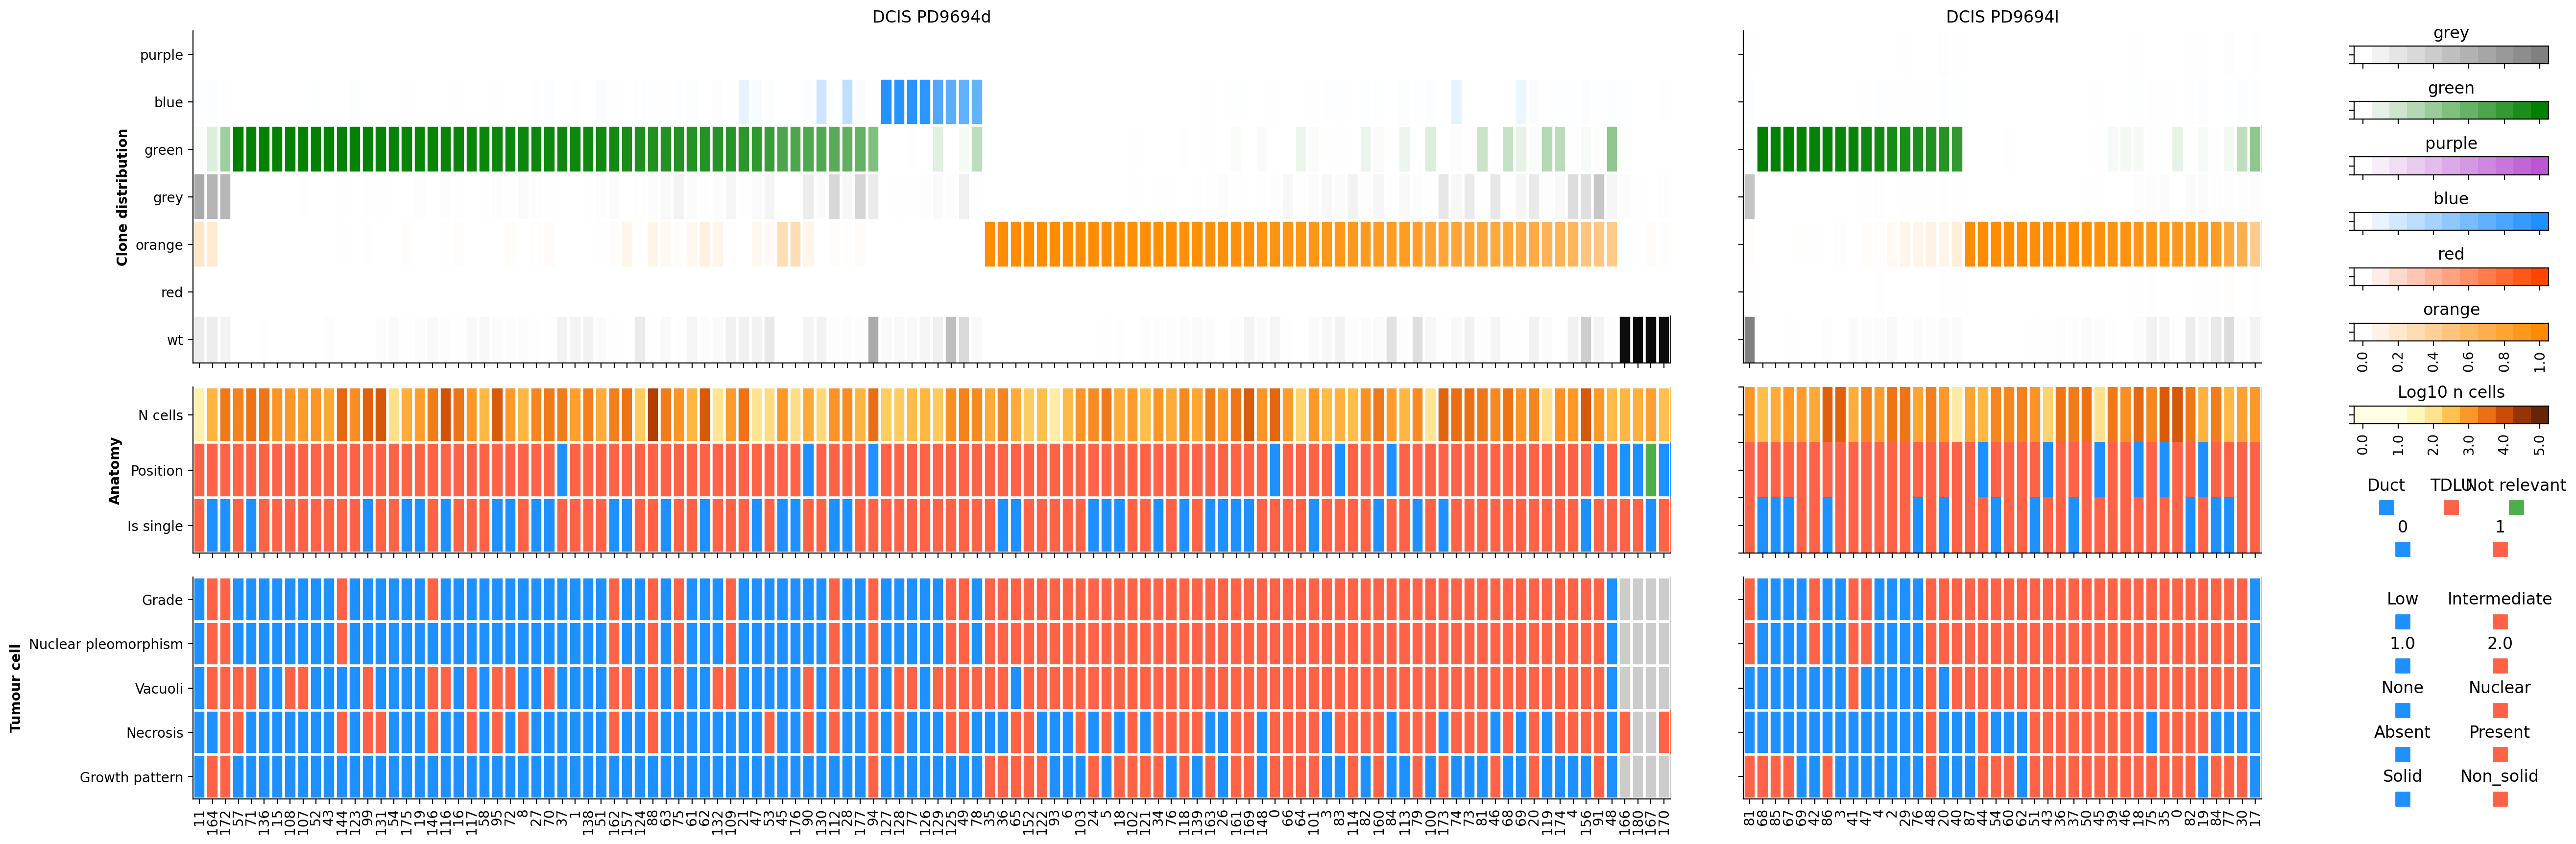

In [23]:
from mpl_toolkits.axes_grid.inset_locator import inset_axes
import matplotlib.patches as patches
from basiss.histology.plots import plot_dcis_histogenomics

plot_dcis_histogenomics(dcis_data)
plt.savefig('../figures/Fig4B_dcis_histogenomics.pdf', dpi=150)

<b>Fig 4E</b> Stacked bar plot summarises histological features of 66 P1-green and 72 P2-orange microregions grouped according to the dominant clone. Nuclear pleomorphism is a measurement of the amount of variability in size and shape of the nuclei and is a major determinant of the histological grade.

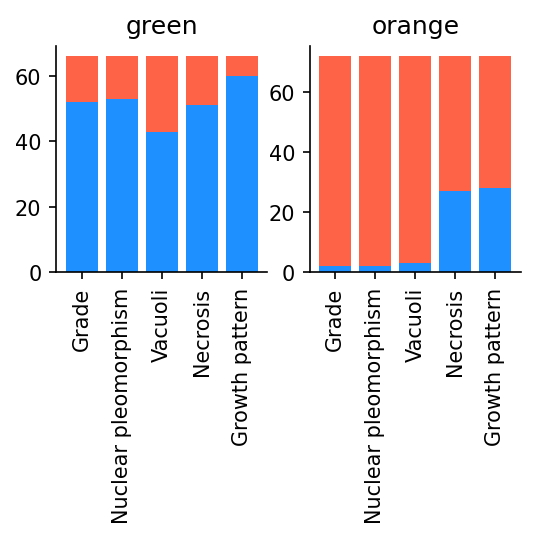

In [24]:
i_s = [0,1]

proportions = [dcis_data[i].comp_matrix.T / dcis_data[i].comp_matrix.T.sum(axis=0)[None,:] for i in i_s]
indices = [[np.where((proportions[i].argmax(0) == 1))[0], np.where((proportions[i].argmax(0) == 5))[0]] for i in i_s]

selected_columns = ['Grade', 'Nuclear pleomorphism', 'Vacuoli', 'Necrosis', 'Growth pattern']

selected_matrix = [dcis_data[i].hist_matrix.loc[:,selected_columns].apply(lambda x: x.cat.codes).values.T for i in i_s]

duct_per_clones = [len(indices[0][i]) + len(indices[1][i])  for i in [0,1]]

dat = []

for hist_cat in range(len(selected_columns)):
    grouping = []
    for clone in range(2):
        unique, counts = np.unique(np.concatenate([selected_matrix[i][hist_cat,indices[i][clone]] for i in range(2)]), return_counts=True)
        grouping.append(dict(zip(unique, counts)))
    dat.append(grouping)
    
plt.figure(figsize=(4,2), dpi=150)
for x in range(2):
    plt.subplot(1,2,x+1)
    for hist_type in range(len(selected_columns)):
        hist_per_clone = [dat[hist_type][x][k] for k in [0,1]]
        plt.bar(hist_type, hist_per_clone[0], bottom=0, facecolor='dodgerblue')
        plt.bar(hist_type, hist_per_clone[1], bottom=hist_per_clone[0], facecolor='tomato')
        
    plt.xticks(np.arange(len(selected_columns)), selected_columns, rotation=90)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.title(['green', 'orange'][x])
plt.savefig('../figures/Fig4E_dcis_histobars.pdf', dpi=150)

### Differential Expression

<b>ED Fig 8A</b> Volcano plot of expression of the 91 oncology ISS panel genes in D2. Significance was adjusted for multiple testing using BH procedure, only genes with $FDR < 0.1$ and fold change $> 1.5$ in both ways are coloured/labelled. The coloured genes are included in the by region plot in

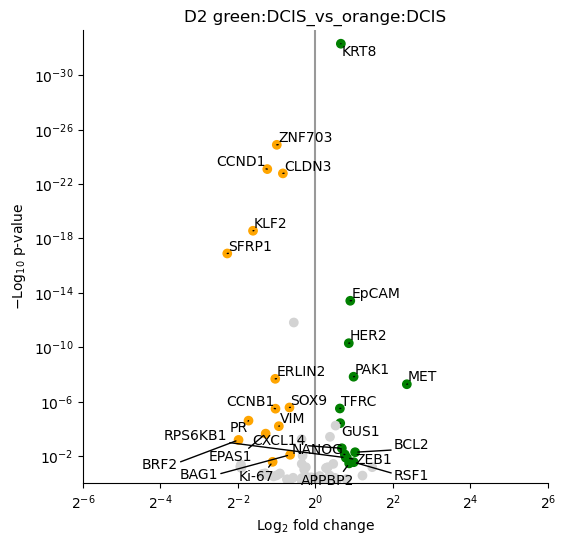

In [25]:
clones = ['grey', 'green', 'purple', 'blue', 'red', 'orange']
sample_id = 3
cell_type = 'Epithelial broad'
cancer_type = ['DCIS', 'DCIS']
ids2compare = [[1], [5]]

name=f'{clones[ids2compare[0][0]]}:{cancer_type[0]}_vs_{clones[ids2compare[1][0]]}:{cancer_type[1]}'
diff_data = np.load(f'../submission/generated_data/glmm/DE_output/{sample_ids[sample_id]}_{cell_type}_{name}.npy')
signal_data = pd.read_csv(f'../submission/generated_data/glmm/DE_input/{sample_ids[sample_id]}_{cell_type}_{name}.csv', index_col=['gene','region'])

genes = np.array(signal_data.index.to_frame()['gene'].astype('category').cat.categories.to_list())

plt.figure(figsize=(6,6), dpi=100)

vulcano_plot_glmm(diff_data, signal_data, colors=[clones[ids2compare[0][0]], clones[ids2compare[1][0]]], adjust=True, pre_test_cut=0, fdr_val_cutoff=0.1)
plt.title(f'D2 {name}')
plt.savefig('../figures/EDFig8A_dcis_cancer_diffexp.pdf', dpi=150)

<b>EDFig 8B</b> Gene expression data within each of the 41 sampled regions in D2. ISS counts in each regions are transformed by applying Poisson cdf with:
$$\lambda = \mu(\textrm{c1-green expression}, \textrm{c1-orange expression}) \times \textrm{nuclei count}$$
in each region, thus divergence from $0.5$ reflects deviation from the global mean expression. Only genes with $FDR < 0.1$ are presented and ordered by the confidence of differential expression in the corresponding clone. 

In [47]:
from scipy.stats import chi2
from basiss.utils.stats import fdr

In [48]:
clones = ['grey', 'green', 'purple', 'blue', 'red', 'orange']
sample_id = 3
cell_type = 'Epithelial broad'
cancer_type = ['DCIS', 'DCIS']
ids2compare = [[1], [5]]

hgas[sample_id].subset_ids(comp_condition = hgas[sample_id].exist_comp_condition())

hgas[sample_id].sort_ids(th=0.4)
cell_df = hgas[sample_id].extra_matrix(iss_panel)
data_matrix = hgas[sample_id].extra_matrix('epithelial')
res = data_matrix.iloc[:,:-1]#.div(cell_df[cell_type],0)
n_cell = cell_df[cell_type]

logdge = np.log2((np.exp(diff_data[:,0,:]) / np.exp(diff_data[:,1,:]))).mean(0)

name=f'{clones[ids2compare[0][0]]}:{cancer_type[0]}_vs_{clones[ids2compare[1][0]]}:{cancer_type[1]}'
diff_data = np.load(f'../submission/generated_data/glmm/DE_output/{sample_ids[sample_id]}_{cell_type}_{name}.npy')
signal_data = pd.read_csv(f'../submission/generated_data/glmm/DE_input/{sample_ids[sample_id]}_{cell_type}_{name}.csv', index_col=['gene','region'])
genes = signal_data.index.to_frame()['gene'].astype('category').cat.categories.to_list()

pre_test_cut = 0.4
mask = (signal_data['value'].sum(level=0)/signal_data['n_nucl'].sum(level=0) * signal_data['n_nucl'].mean(level=0)) > pre_test_cut
delta = diff_data[:,0,:] - diff_data[:,1,:]
z = delta.mean(0)/delta.std(0)
p = chi2.sf(z**2,1)
fdr_val = p.copy()
fdr_val[mask] = fdr(p[mask])
fdr_val[~mask] = 1

limit = fdr_val < 0.1

logdge = logdge[limit]
fdr_val = fdr_val[limit]

sorting_ids = np.argsort(np.array(list(map(lambda x: (~(logdge[x] > 0), fdr_val[x] * np.sign(logdge[x])), np.arange(limit.sum()))) + [None], dtype=tuple)[:-1])


/nfs/research/gerstung/alomakin/projects/bassis/repo/BaSISS/notebooks/../basiss/histology/_histogenomic.py:84: RuntimeWarning: invalid value encountered in double_scalars
  if self.composition_dict[item].mean(axis=0)[:-1].sum() / self.composition_dict[item].mean(axis=0).sum()  > th:


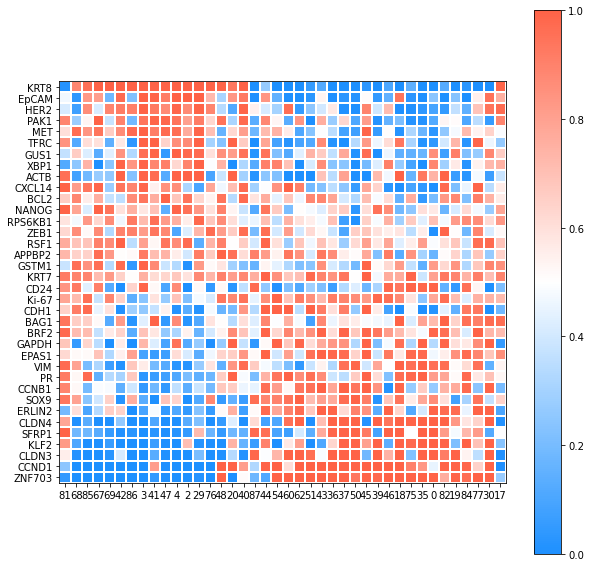

In [49]:
import scipy.stats as st
z = np.array([st.poisson(mu=np.exp(diff_data).mean(0).mean(0)[limit][i] * n_cell).cdf(res.iloc[:,limit].iloc[:,i]) for i in range(limit.sum())])
#z = np.array([st.nbinom(*convert_params(np.exp(diff_data).mean(0).mean(0)[limit][i] * n_cell, 0.00001)).cdf(res.iloc[:,limit].iloc[:,i]) for i in range(limit.sum())])

#z = np.array([np.log2(res.iloc[:,limit].iloc[:,i] / (np.exp(diff_data).mean(0).mean(0)[limit][i] * n_cell)) for i in range(limit.sum())])
cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["dodgerblue","white","tomato"])

plt.figure(figsize=(10,10))
plt.imshow(z[sorting_ids], cmap=cmap, vmin=0, vmax=1)
plt.yticks(np.arange(limit.sum()), np.array(genes)[limit][sorting_ids]);
plt.xticks(np.arange(len(hgas[sample_id].common_ids)), hgas[sample_id].common_ids);
plt.gca().set_yticks(np.arange(limit.sum()+1) - .5, minor=True)
plt.gca().set_xticks(np.arange(len(hgas[sample_id].common_ids)+1) - .5, minor=True)
plt.gca().tick_params(which='minor', length=0)    
plt.gca().grid(which='minor', color='w', linestyle='-', linewidth=2)
plt.colorbar()
plt.savefig(f'../figures/EDFig8B_diffexp_by_region_D2.pdf')

#### Density plot for regions of interests
<b>Ed Fig 7D</b> frequency plots of the local, mean cancer (coloured areas) and non-cancer (white) composition

In [50]:
from basiss.plots import plot_density_stacked


Text(0.5, 0, 'Distance, mm')

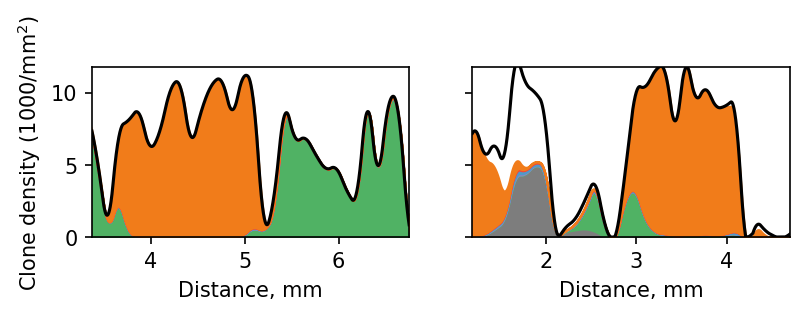

In [51]:
i = 3
pixel2um=0.325
grid_mm2 = (mut_sample_list_case1[i].spatial_dims[0] \
            * pixel2um / model_params_samples_case1[f'F_{i}'].shape[1]) ** 2/ 1e6

fig, axs = plt.subplots(1,2,figsize=(3*2,1.5), dpi=150, sharey=True)
plot_density_stacked(model_params_samples_case1[f'F_{i}'],
                     model_params_samples_case1[f'lm_n_{i}'],
                     51,
                     names = ['grey', 'green', 'purple', 'blue', 'red', 'orange', 'wt'],
                     wt_colour='black',
                     grid_mm2 = grid_mm2,
                     flipped=True,
                     ax=axs[0],
                     rescale_x=mut_sample_list_case1[i].spatial_dims[0] / 1000 * 0.325)
axs[0].set_xlim(3.48 - 0.108, 6.86- 0.108)
plot_density_stacked(model_params_samples_case1[f'F_{i}'],
                     model_params_samples_case1[f'lm_n_{i}'],
                     24,
                     names = ['grey', 'green', 'purple', 'blue', 'red', 'orange', 'wt'],
                     wt_colour='black',
                     grid_mm2 = grid_mm2,
                     flipped=True,
                     ax=axs[1],
                     rescale_x=mut_sample_list_case1[i].spatial_dims[0] / 1000 * 0.325)
axs[1].set_xlim(1.3 - 0.108, 4.797- 0.108)

axs[0].set_ylabel('Clone density (1000/mm$^2$)')
axs[0].set_xlabel('Distance, mm')
axs[1].set_xlabel('Distance, mm')

## ER1, ER2, LN1 analysis

### Histogenomic heatmaps

<b>Fig 3B</b> Heatmaps report clone composition in 34 and 44 histologically annotated epithelial containing microregions of ER1 and ER2, respectively. Microregions include individual ducts or randomly selected similarly sized regions of invasive cancer, (see Extended Data Figure 4b and 5b and <a href="https://www.cancerclonemaps.org/">web browser</a> for micreoregion details)

In [52]:
from basiss.histology.plots import plot_by_epith_extra

In [53]:
sample_names = ['PD9694' + x for x in 'dacl'] + ['PD14780' + x for x in 'ae']

[(7, 0), (7, 0), (7, 12), (7, 22)]


/nfs/research/gerstung/alomakin/projects/bassis/repo/BaSISS/notebooks/../basiss/histology/_histogenomic.py:84: RuntimeWarning: invalid value encountered in double_scalars
  if self.composition_dict[item].mean(axis=0)[:-1].sum() / self.composition_dict[item].mean(axis=0).sum()  > th:


[(7, 1), (7, 3), (7, 21), (7, 19)]


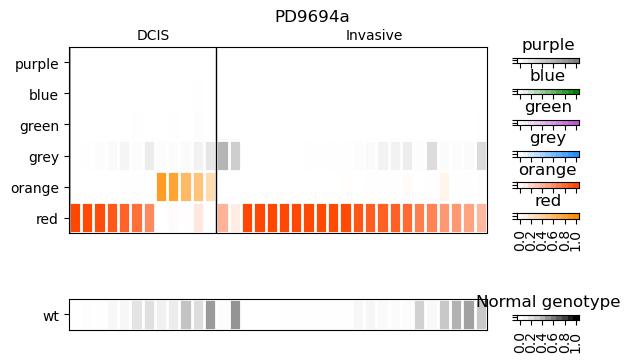

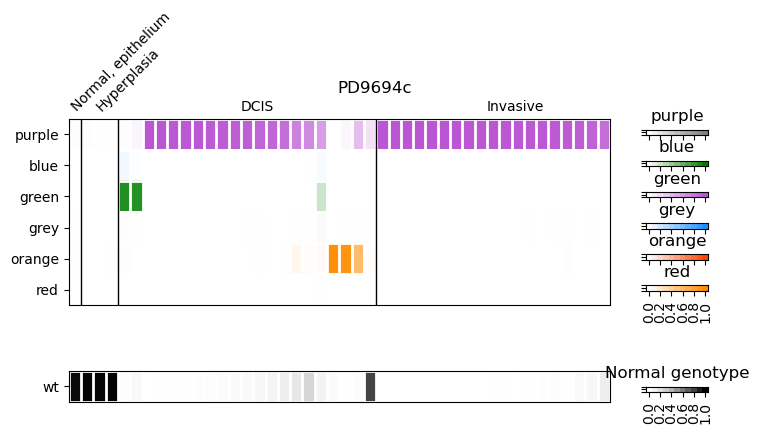

In [54]:
for i in [1,2]:
    plot_by_epith_extra(hgas[i],
                  sbcl_names = ['grey', 'green', 'purple', 'blue', 'red', 'orange'],
                  epith_names = ['Normal, epithelium',  'Hyperplasia', 'DCIS', 'Invasive'],
                  hist_columns = None,
                  title=sample_names[i],
                  reorder=[2,3,1,0,5,4],
                  th=0.4)
    plt.savefig(f'../figures/Fig3B_histo_heatmap_{["D1","ER1", "ER2"][i]}.pdf')

<b>ED Fig 5F</b> Violin plots depict clone specific gene expression posterior density of the generalised linear mixed models (glmm) model with region specific random effect. Significant comparisons were controlled for FDR using the BH procedure. 36 regions of ER2 with a dominant clone fraction > 0.7 were analysed.

In [55]:
from basiss.utils.stats import fdr
from basiss.histology import signif_comparisons

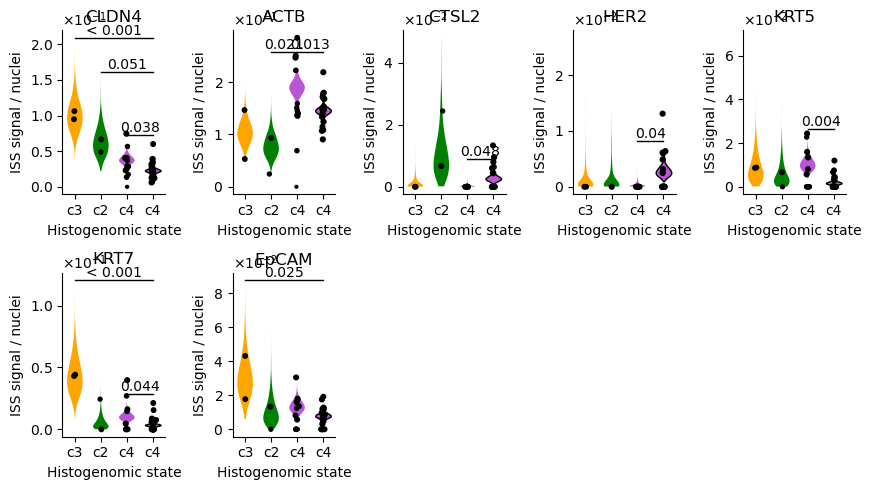

In [56]:
sample_id = 2
cell_type = 'Epithelial broad'
cancer_types = np.array(['DCIS', 'DCIS', 'DCIS', 'Invasive'])
ids2compares = np.array([1,2,5,2])
    
diff_data = np.load(f'../submission/generated_data/glmm/multiregion_output/{sample_ids[sample_id]}_{cell_type}.npy')
signal_data = pd.read_csv(f'../submission/generated_data/glmm/multiregion_input/{sample_ids[sample_id]}_{cell_type}.csv', index_col=['gene','region'])

signif_gene_pval = signif_comparisons(diff_data, signal_data, comparisons = [[0,3], [1,3], [2,3], [0,1]], fdr_th=0.1, pre_test_cut=0.3)
signif_gene_ids = list(signif_gene_pval.keys())

all_genes = np.array(signal_data.index.to_frame()['gene'].astype('category').cat.categories.to_list())
gene_indices = signif_gene_ids
genes = list(all_genes[gene_indices])

clones = ['grey', 'green', 'purple', 'blue', 'red', 'orange']
clone_colors = ['grey', 'green', 'mediumorchid', 'blue', 'red', 'orange']


order = np.array([2,0,1,3])
n_clones = len(ids2compares)
np.random.seed(42)
plt.figure(figsize=(len(genes)/2*2.5,5), dpi=100)
for i, genedat in enumerate(zip(genes, gene_indices)):
    gene, gene_id = genedat
    plt.subplot(2, 5, i+1)
    vp = plt.violinplot([np.exp(diff_data[:,c,gene_id]) for c in order], positions = np.arange(n_clones), showextrema=False, widths=0.6, bw_method=0.4)
    
    for c, body in zip(order, vp['bodies']):
        body.set_alpha(1)
        body.set_facecolor(clone_colors[ids2compares[c]])
        if cancer_types[c] == 'Invasive':
            body.set_edgecolor([0,0,0,1])
            body.set_linewidth(1)
            body.set_linestyle('-')
        
    jit = np.random.randn(signal_data.loc[gene].shape[0]) / 30
    plt.scatter(np.array([np.where(order == x)[0]  for x in signal_data.loc[gene,"clone_id"]]) + jit[:,None],
                signal_data.loc[gene,"value"]/signal_data.loc[gene,"n_nucl"], alpha=1, color='black', s= np.log10(signal_data.loc[gene,"n_nucl"]) * 5)
    
    x_names = [f'c{ids2compares[c]}-{cancer_types[c]}' for c in order]

    for pos, fdr_val in signif_gene_pval[gene_id].items():
        num1, num2 = np.where(np.array(x_names) == f'c{ids2compares[pos[0]]}-{cancer_types[pos[0]]}')[0], np.where(np.array(x_names) == f'c{ids2compares[pos[1]]}-{cancer_types[pos[1]]}')[0]
        boxplot_annotate_brackets(num1, num2, np.arange(n_clones), np.array([np.exp(diff_data[:,c,gene_id]).max() for c in order]), str(round(fdr_val, 3)) if round(fdr_val, 3) != 0 else '< 0.001')
    plt.title(gene)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.xlabel('Histogenomic state')
    plt.xticks(np.arange(n_clones), ['c' + str(np.array([0,2,4,1,5,3])[int(x.split('-')[0][1])]) for x in x_names])
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
    plt.ylabel('ISS signal / nuclei')    
    
plt.tight_layout()
#plt.savefig(f'../figures/EDFig5F_ER2_multiregion_expression.pdf')

<b>ED Fig 5E</b> Violin plots depict clone specific Ki67 IHC staining rate posterior density of the generalised linear mixed model (glmm) with region specific random effect. Significant comparisons were controlled for FDR using the BH procedure. Analysis was limited to the 11 regions with confirmed clone compositions by WGS due to variation between IHC and BaSISS sections in z-stack morphology (relates to Fig. 2d)

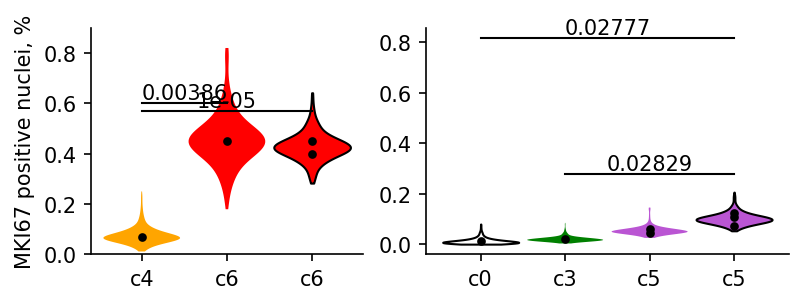

In [57]:
clone_colors = {'c1':'grey', 'c3':'green', 'c5':'mediumorchid', 'c2':'blue', 'c6':'red', 'c4':'orange', 'c0':'white'}


data = pd.read_csv('../submission/generated_data/glmm/composition_input/PD9694_ihc.csv')
data = data.set_index(['clone', 'state'])
xticks = []
xticklabels = []
for i, histo_genomic_state in enumerate(data.index.unique()[[0,2,1,6,5,3,4]]):
    xticks.append(i)
    xticklabels.append(histo_genomic_state[0])
    
with open('../submission/generated_data/glmm/composition_ouput/PD9694_ihc.pkl', 'rb') as file:
    estimations = pkl.load(file)[0]
positive = np.exp(estimations)[:,:,1] / np.exp(estimations).sum(axis=2)[:,:]

pairwise_comparisons = [[0,2], [0,1], [1,2], [3,4], [4,5], [5,6], [3,5], [3,6], [4,6]]

p_values = []
for pc in pairwise_comparisons:
    delta = positive[:,pc[0]] - positive[:,pc[1]]
    z = delta.mean(0)/delta.std(0)
    p = chi2.sf(z**2,1)
    p_values.append(p)
fdr_values = np.stack(p_values)
fdr_values = fdr(fdr_values.reshape(-1)).reshape(fdr_values.shape)

fig, axs = plt.subplots(1,2,figsize=(3*2,2), dpi=150, gridspec_kw={'width_ratios':[3, 4]})
for i in np.arange(len(df.clone_id.unique()))[:3]:
    data = df[(df.clone_id == i) & (df.cell == 'Positive')]
    ratio = data.value / data.Total
    vp = axs[0].violinplot(positive[:,i][(positive[:,i] < np.percentile(positive[:,i], 99)) & (positive[:,i] > np.percentile(positive[:,i], 1))],
                    positions=[xticks[i]], showextrema=False, widths=0.9, bw_method=0.4)
    for body in vp['bodies']:
        body.set_alpha(1)
        body.set_facecolor(clone_colors[data.clone.iloc[0]])
        if data.state.iloc[0] == 'Inv':
            body.set_edgecolor('black')
            body.set_linewidth(1)
        elif data.state.iloc[0] == 'ahyp':
            body.set_edgecolor('black')
            body.set_linewidth(1)
    axs[0].scatter([xticks[i]] * len(ratio), ratio, color='black', alpha=1, s=10)

dh_extra = 0
for i, ps in enumerate(pairwise_comparisons[:3]):
    
    if fdr_values[i] < 0.1:
        boxplot_annotate_brackets(0, 1, [xticks[ps[0]], xticks[ps[1]]], [np.max(positive[:,ps[0]]), np.max(positive[:,ps[1]])], str(np.round(fdr_values[i],5)), dh=-0.1 + dh_extra, ax=axs[0])
        dh_extra -= 0.15
        
axs[0].set_xticks(xticks[:3])
axs[0].set_xticklabels(xticklabels[:3])
axs[0].set_ylabel('MKI67 positive nuclei, %')
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[0].set_ylim(0,0.9)

xticks = np.array(xticks)-3
for i in np.arange(len(df.clone_id.unique()))[3:]:
    data = df[(df.clone_id == i) & (df.cell == 'Positive')]
    ratio = data.value / data.Total
    vp = axs[1].violinplot(positive[:,i][(positive[:,i] < np.percentile(positive[:,i], 99)) & (positive[:,i] > np.percentile(positive[:,i], 1))],
                    positions=[xticks[i]], showextrema=False, widths=0.9, bw_method=0.4)
    for body in vp['bodies']:
        body.set_alpha(1)
        body.set_facecolor(clone_colors[data.clone.iloc[0]])
        if data.state.iloc[0] == 'Inv':
            body.set_edgecolor('black')
            body.set_linewidth(1)
        elif data.state.iloc[0] == 'ahyp':
            body.set_edgecolor('black')
            body.set_linewidth(1)
    axs[1].scatter([xticks[i]] * len(ratio), ratio, color='black', alpha=1, s=10)

dh_extra = 0
for i, ps in enumerate(pairwise_comparisons[3:]):
    i += 3
    if fdr_values[i] < 0.1:
        boxplot_annotate_brackets(0, 1, [xticks[ps[0]], xticks[ps[1]]], [np.max(positive[:,ps[0]]), np.max(positive[:,ps[1]])], str(np.round(fdr_values[i],5)), dh=0.01 + dh_extra, ax=axs[1])
        dh_extra -= 0.15
        
axs[1].set_xticks(xticks[3:])
axs[1].set_xticklabels(xticklabels[3:])
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
plt.savefig(f'../figures/EDFig5E_MKI67_positive_ER1_ER2.pdf')


In [58]:
#raw numbers
data = pd.read_csv('../submission/generated_data/glmm/composition_input/PD9694_ihc.csv')
for clone in ['c6', 'c4', 'c5', 'c3']:
    condition = (data['clone'] == clone) & (data['cell'] == 'Positive')
    print(clone, round(data[condition].value.sum()  / data[condition].Total.sum(), 3))

c6 0.429
c4 0.069
c5 0.09
c3 0.019


<b>Fig 3F</b> Heatmaps report clone composition in 36 histologically annotated microregions in  TN1, only regions with epithelial tissue are presented. Lower heatmap reports histopathologist estimated growth pattern contributions.

[(5, 0), (5, 0), (5, 4), (5, 32)]


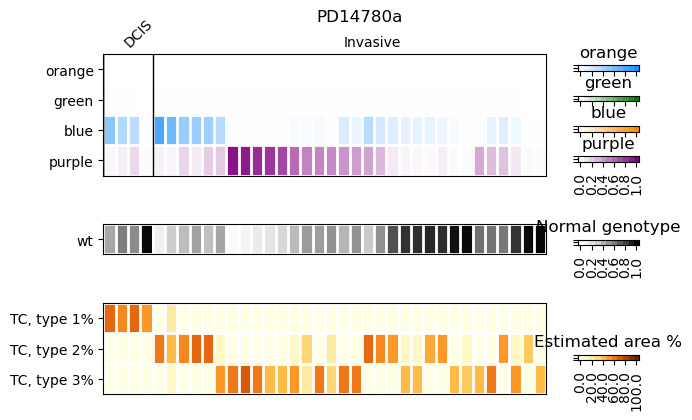

In [59]:
i = 4
plot_by_epith_extra(hgas[i],
                  sbcl_names = ['blue', 'green', 'orange', 'purple'],
                  epith_names = ['Normal, epithelium',  'Hyperplasia', 'DCIS', 'Invasive'],
                  hist_columns = ['TC, type 1%', 'TC, type 2%', 'TC, type 3%'],
                  title=sample_names[i],
                  reorder=[2,1,0,3],
                  th=0.4)
plt.savefig(f'../figures/Fig3F_histo_heatmap_TN1.pdf')

Contributions of blue and purple clones to regions with TC2 and TC3 morphologies. Fisher exact test was used to test if contributions are different.

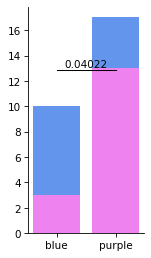

In [60]:
i = 4
hgas[i].subset_ids(hist_condition=np.isin(hgas[i].histology_df['Histo_type'], ['TC2', 'TC3']))
proportions = hgas[i].comp_matrix.T / hgas[i].comp_matrix.T.sum(axis=0)[None,:]
indices = np.where((proportions[:-1].argmax(0) == 0) & (proportions[:-1,:].sum(0) > 0.15))[0], np.where((proportions[:-1].argmax(0) == 3) & (proportions[:-1,:].sum(0) > 0.15))[0]


cancer_type = ['TC2', 'TC3']

grouping = []
for clone in range(2):
    counts = Counter(np.isin(hgas[i].hist_matrix['Histo_type'][indices[clone]], cancer_type[0]).astype(int))
    grouping.append({x : counts[x] for x in range(2)})

plt.figure(figsize=(2,4), dpi=75)
for clone in range(2):
    plt.bar(clone, grouping[clone][0], bottom=None, color = 'violet')
    plt.bar(clone, grouping[clone][1], bottom=grouping[clone][0], color = 'cornflowerblue')
    
plt.xticks(np.arange(2), ['blue', 'purple'])
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

boxplot_annotate_brackets(0, 1, [0,1], [6,12], str(np.round(fisher_exact(np.array([[grouping[x][k] for k in [0,1]] for x in [0,1]]))[1],5)), dh=0.05)
#plt.savefig(f'../data/fields_publication_size/figures/Fig4_{sample_names[i]}_histogenomic_barplot.pdf')


<b>ED Fig 6D</b> Volcano plot of expression of the 91 oncology ISS panel genes in TN1 invasive regions. Significance was adjusted for multiple testing using BH procedure, only genes with $FDR < 0.1$ and fold change $> 1.5$ in both ways are coloured/labelled. Purple - expression is higher in TC3 areas occupied by purple clones, blue - expression is higher in TC2 areas occupied by blue clone

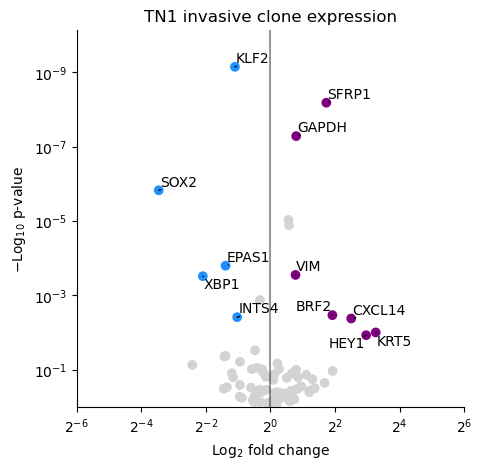

In [61]:
plt.rcParams['figure.facecolor'] = 'w'

clones = ['dodgerblue', 'green', 'darkorange', 'purple']

# TN1
sample_id = 4
cell_type = 'Epithelial broad'


cancer_type = ['TC3', 'TC2']
ids2compare = [[3], [0]]

plt.figure(figsize=(5,5), dpi=100)


name=f'{clones[ids2compare[0][0]]}:{cancer_type[0]}_vs_{clones[ids2compare[1][0]]}:{cancer_type[1]}'

diff_data = np.load(f'../submission/generated_data/glmm/DE_output/{sample_ids[sample_id]}_{cell_type}_{name}.npy')
signal_data = pd.read_csv(f'../submission/generated_data/glmm/DE_input/{sample_ids[sample_id]}_{cell_type}_{name}.csv', index_col=['gene','region'])
genes = signal_data.index.to_frame()['gene'].astype('category').cat.categories.to_list()

vulcano_plot_glmm(diff_data, signal_data, colors=[clones[ids2compare[0][0]], clones[ids2compare[1][0]]],
                  fold_change_cutoff=1.5,
                  adjust=True, pre_test_cut=0.3, fdr_val_cutoff=0.1)
plt.title(f'TN1 invasive clone expression')
plt.savefig(f'../figures/EDFig6D_TN1_cancer_diffexp.pdf', dpi=150)

<b>ED Fig 6E</b> Violin plots depict clone specific cell type contribution posterior density of the generalised linear mixed models (glmm) model with region specific random effect. Significant comparisons were controlled for FDR using the BH procedure. 19 clone territories (with dominant clone fraction > 0.1) in TN1 were analysed. Fibroblasts and perivascular-like cells (PVL) could not be differentiated within this experiment and are reported as ‘fibroblasts’. Colour coding
* blue - blue clone in DCIS
* blue with black outline - blue clone with Invasive TC2 morphology
* purple with black outline - purple clone with Invasive TC3 morphology

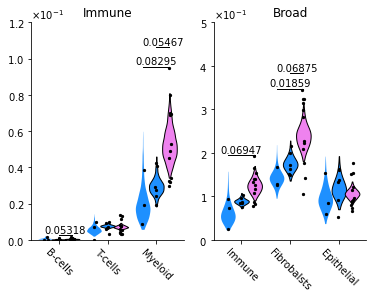

In [62]:
from basiss.histology.plots import plot_cell_composition


sample_id=4
ids2compare = [0,0,3]
cancer_type = ['TC1', 'TC2', 'TC3']

colors = ['dodgerblue', 'green', 'darkorange', 'violet']

data = pd.read_csv(f"../submission/generated_data/glmm/composition_input/{sample_ids[sample_id]}.csv", index_col=['cell','region', 'panel'])
with open(f'../submission/generated_data/glmm/composition_ouput/{sample_ids[sample_id]}.pkl', 'rb') as file:
    composition_estimates = pkl.load(file)

plot_cell_composition(data, composition_estimates, ids2compare,
                      cancer_type=cancer_type, colors=colors)
plt.savefig(f'../figures/EDFig6E_TN1_cell_composition.pdf')

## Lymph node (LN1) analysis

### histogenomic associations
<b>Fig 5D</b> Heatmaps report clone composition in 39 histologically annotated regions (regions with 5% or more tumour cells are included). Lower heatmap reports histopathologist estimated growth pattern contributions.

In paper notations 
* 'MC1', 'MC4' = M-GP2
* 'MC2' = M-GP1

[(5, 19), (5, 20)]


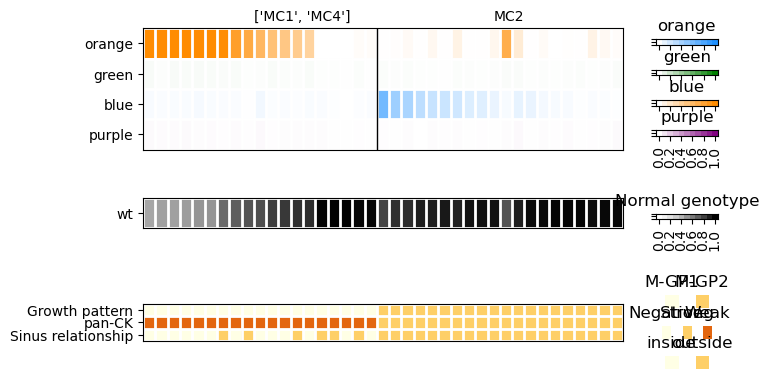

In [63]:
i=5
plot_by_epith_extra(hgas[i],
              sbcl_names = ['blue', 'green', 'orange', 'purple'],
              epith_names = [['MC1', 'MC4'], 'MC2'],
              hist_columns = ['Growth pattern', 'pan-CK', 'Sinus relationship'],
              reorder=[2,1,0,3],
              th=0.05,
              colorscale=3,
              plot_labels=False)
plt.savefig(f'../figures/Fig5D_histo_heatmap_LN1.pdf')

Contributions of blue and purple clones to regions with M-GP1 and M-GP2 morphologies. Fisher exact test was used to test if contributions are different.

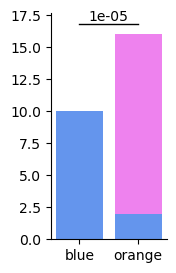

In [64]:
i = 5
hgas[i].subset_ids(hist_condition=np.isin(hgas[i].histology_df['Epithelial cells'], ['MC1', 'MC2', 'MC4']))
proportions = hgas[i].comp_matrix.T / hgas[i].comp_matrix.T.sum(axis=0)[None,:]
indices = np.where((proportions[:-1].argmax(0) == 0) & (proportions[:-1,:].sum(0) > 0.05))[0], np.where((proportions[:-1].argmax(0) == 2) & (proportions[:-1,:].sum(0) > 0.05))[0]


growth_type = ['M-GP1', 'M-GP2']

grouping = []
for clone in range(2):
    counts = Counter(np.isin(hgas[i].hist_matrix['Growth pattern'][indices[clone]], growth_type[0]).astype(int))
    grouping.append({x : counts[x] for x in range(2)})

plt.figure(figsize=(1.5,3), dpi=100)
for clone in range(2):
    plt.bar(clone, grouping[clone][0], bottom=None, color = 'cornflowerblue')
    plt.bar(clone, grouping[clone][1], bottom=grouping[clone][0], color = 'violet')
    
plt.xticks(np.arange(2), ['blue', 'orange'])
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

boxplot_annotate_brackets(0, 1, [0,1], [10,16], str(np.round(fisher_exact(np.array([[grouping[x][k] for k in [0,1]] for x in [0,1]]))[1],5)), dh=0.05)


### Differential expression
<b>Fig 5E,F</b> Volcano plot of the 91 genes in the ISS oncology panel expressed by epithelial cells (top) and 62 genes in the ISS immune panel expressed by immune cells (bottom). Significantly ($FDR > 0.1$), differentially expressed (fold change $> 1.5$ both ways) genes are coloured. Orange - higher in regions occupied by orange clone with M-GP2 patter. Blue - higher in regions occupied by blue clone with M-GP1 patter.


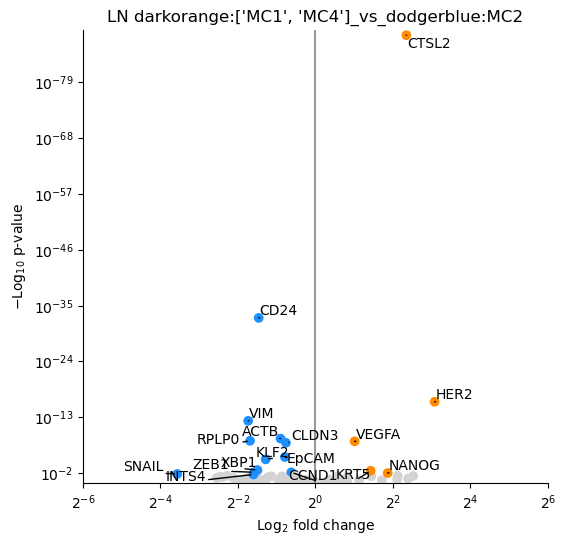

In [65]:
#### cancer expression
np.random.seed(0)
clones = ['dodgerblue', 'green', 'darkorange', 'purple']

# LN
sample_id = 5
cell_type = 'Epithelial broad'

plt.figure(figsize=(6*1,6), dpi=100)

cancer_types = [[['MC1','MC4'], 'MC2']]
ids2compares = [[[2], [0]]]


for i in range(len(cancer_types)):
    cancer_type = cancer_types[i]
    ids2compare = ids2compares[i]
    
    name=f'{clones[ids2compare[0][0]]}:{cancer_type[0]}_vs_{clones[ids2compare[1][0]]}:{cancer_type[1]}'
            
    diff_data = np.load(f'../submission/generated_data/glmm/DE_output/{sample_ids[sample_id]}_{cell_type}_{name}.npy')
    signal_data = pd.read_csv(f'../submission/generated_data/glmm/DE_input/{sample_ids[sample_id]}_{cell_type}_{name}.csv', index_col=['gene','region'])
    genes = signal_data.index.to_frame()['gene'].astype('category').cat.categories.to_list()

    #plt.subplot(1,2,1)
    vulcano_plot_glmm(diff_data, signal_data, colors=[clones[ids2compare[0][0]], clones[ids2compare[1][0]]], adjust=True, pre_test_cut=0, fdr_val_cutoff=0.1)
    plt.title(f'LN {name}')
    #plt.ylim(1, 1e-30)
plt.savefig(f'../figures/Fig5F_cancer_difexp.pdf', dpi=150)

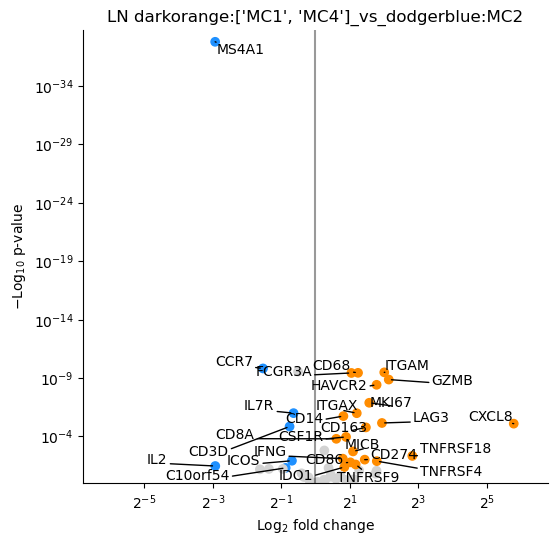

In [66]:
plt.figure(figsize=(6*1,6), dpi=100)
cell_type = 'Immune total'
for i in range(len(cancer_types)):
    cancer_type = cancer_types[i]
    ids2compare = ids2compares[i]
    
    name=f'{clones[ids2compare[0][0]]}:{cancer_type[0]}_vs_{clones[ids2compare[1][0]]}:{cancer_type[1]}'
            
    diff_data = np.load(f'../submission/generated_data/glmm/DE_output/{sample_ids[sample_id]}_{cell_type}_{name}.npy')
    signal_data = pd.read_csv(f'../submission/generated_data/glmm/DE_input/{sample_ids[sample_id]}_{cell_type}_{name}.csv', index_col=['gene','region'])
    genes = signal_data.index.to_frame()['gene'].astype('category').cat.categories.to_list()
    vulcano_plot_glmm(diff_data, signal_data, colors=[clones[ids2compare[0][0]], clones[ids2compare[1][0]]], adjust=True, pre_test_cut=0, fdr_val_cutoff=0.1)
    plt.title(f'LN {name}')
plt.savefig(f'../figures/Fig5E_immune_deffexp.pdf')

### Cellular composition

<b>Fig 5G</b> Violins depict clone specific cell type contribution posterior density of the glmm model with region specific random effect. The 22 clone territories with a dominant clone fraction > 0.05 in LN1 are included. Significant comparisons were controlled for FDR using the BH procedure

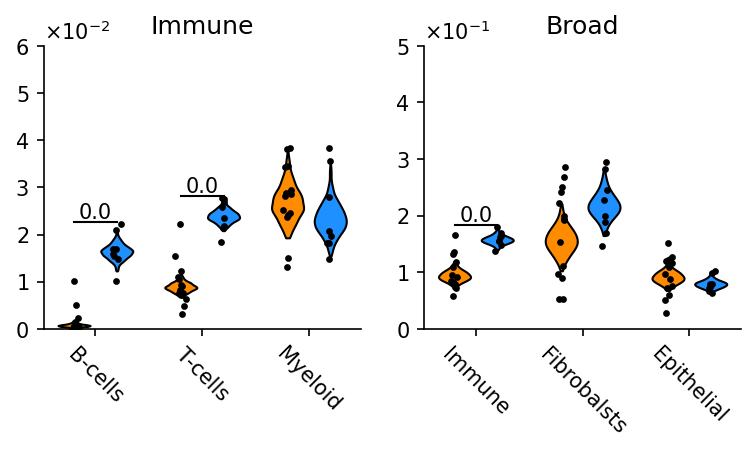

In [67]:
from scipy.stats import chi2


sample_id=5
ids2compare = [2,0]
cancer_types = [[['MC1','MC4'], 'MC2']]

colors = ['dodgerblue', 'green', 'darkorange', 'violet']

n_histogenomic_groups = len(ids2compare)

data = pd.read_csv(f"../submission/generated_data/glmm/composition_input/{sample_ids[sample_id]}.csv", index_col=['cell','region', 'panel'])
with open(f'../submission/generated_data/glmm/composition_ouput/{sample_ids[sample_id]}.pkl', 'rb') as file:
    composition_estimates = pkl.load(file)

plt.figure(figsize=(4*1.5,2.5), dpi=150)
plot_cell_composition(data, composition_estimates, ids2compare,
                      cancer_type=cancer_type, colors=colors, ylims=(0.06,0.5))
plt.savefig(f'../figures/Fig5G_LN_cell_composition.pdf')